## RFM(Recency, Frequency, Monetary)

* RFM은 가치있는 고객을 추출해내어 이를 기준으로 고객을 분류할 수 있는 매우 간단하면서도 유용하게 사용될 수 있는 방법으로 알려져 있어 마케팅에서 가장 많이 사용되고 있는 분석방법 중 하나이다. RFM은 구매 가능성이 높은 고객을 선정하기 위한 데이터 분석방법으로서, 분석과정을 통해 데이터는 의미있는 정보로 전환된다.

* RFM은 Recency, Frequency, Monetary의 약자로 고객의 가치를 다음의 세 가지 기준에 의해 계산하고 있다.

* Recency - 거래의 최근성: 고객이 얼마나 최근에 구입했는가?
* Frequency - 거래빈도: 고객이 얼마나 빈번하게 우리 상품을 구입했나?
* Monetary - 거래규모: 고객이 구입했던 총 금액은 어느 정도인가?

### RFM 모형

* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 이 문서의 내용들은 정설이 아니며 신뢰하기 어려움을 전제로 참고해야한다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
* Data Mining 기법을 이용한 모형
* 회귀분석
* 선형 회귀 분석을 이용한 모형: 고객의 구매 최근성, 구매 빈도, 구매 금액 등 고객의 수익 기여도를 나타내는 세가지 지표들의 선형결합으로 세가지 지표들을 점수화 한다.
* 다중 회귀 분석을 이용한 모형: 각 고객의 구매 행동을 나타내는 R,F,M의 변수들을 독립변수로하고 고객의 미래 구매 행동을 예측하는 기법.
* 신경망을 적용한 모형: 로지스틱 회귀 모형을 보완하는 차원에서 연구.
* 확률적 RFM모형:Colombo와 Weina의 확률적인 RFM모형은 과거의 고객의 응답 이력으로 고객의 미래 응답을 예측하는 행동모델이다.

출처 : [RFM - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/RFM)




### 파레토 법칙
    * 상위 고객의 20%가 기업 총 매출의 80%를 차지한다. 
    * 80:20 법칙을 고려하면 고객 매출 데이터가 누적됨에 따라 마케팅에 데이터를 활용해 마케팅에 활용할 수 있다.
    
    
### 고객 세분화
    * 상품과 서비스 판매정보 - 상품판매 자료 거래 금액, 횟수
    * 인구통계학적 정보 - 나이, 성별, 직업, 학력, 거주지역, 소득수준
    * 라이프 스타일 정보 - 순차적, 구매 정보, RFM 정보
    * 심리 정보 - 구매욕구
    * 행동 정보 - 구매패턴 Life Time Value
    
    
### RFM 관련 논문

[국회도서관 소장자료검색 전체](http://dl.nanet.go.kr/law/SearchDetailView.do?cn=KDMT1200458026#none)

## 라이브러리 로드

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt

## 폰트설정

In [2]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux
        # colab에서는 runtime을 <꼭> 재시작 해야합니다.
        # 런타임을 재시작 하지 않고 폰트 설치를 하면 기본 설정 폰트가 로드되어 한글이 깨집니다.
        !apt-get update -qq
        !apt-get install fonts-nanum -qq  > /dev/null

        import matplotlib.font_manager as fm

        fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
        font = fm.FontProperties(fname=fontpath, size=9)
        fm._rebuild()
        font_family = "NanumBarunGothic"
    return font_family

plt.rc("font", family=get_font_family())
plt.rc("axes", unicode_minus=False)

## 데이터 로드

In [3]:
# raw = pd.read_excel("http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx")
# raw = pd.read_excel("data/Online Retail.xlsx", engine="openpyxl")
raw = pd.read_csv("data/online_retail.csv")
raw.shape

(541909, 8)

In [4]:
raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## 유효 데이터만 추출

In [5]:
# "CustomerID" 가 있고 "Quantity" 가 0보다 큰 데이터를 가져옵니다.
# 구매하고 취소한 건 중 취소한 건만 제외하고 구매 건은 남깁니다.
raw_valid= raw[raw["CustomerID"].notnull() & (raw["Quantity"] > 0) & (raw["UnitPrice"] > 0)].copy()
raw_valid.shape

(397884, 8)

## 구매 금액 계산

In [6]:
raw_valid["TotalPrice"] = raw_valid["UnitPrice"] * raw_valid["Quantity"]

In [7]:
raw_valid["TotalPrice"].describe()

count    397884.000000
mean         22.397000
std         309.071041
min           0.001000
25%           4.680000
50%          11.800000
75%          19.800000
max      168469.600000
Name: TotalPrice, dtype: float64

## 이상치 제거

In [8]:
# 이상치 찾기
raw_valid[raw_valid["TotalPrice"] > 160000]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.6


In [9]:
# 이상치는 제외합니다.
raw_valid = raw_valid[raw_valid["TotalPrice"] < 160000]
raw_valid.shape

(397883, 9)

## 중복 데이터 확인
* 중복 데이터는 여러 이유로 발생할 수 있습니다. 네트워크 통신 문제나 쇼핑몰의 UI 구성 등의 다양한 이슈로 발생할 수 있습니다.
* 예를 들면 주문을 하고 새로고침을 했을 때 다시 주문 트랜잭션에 들어가거나 하는 이슈가 발생할 가능성도 있습니다.

In [10]:
# 중복 데이터 중 첫번째 것만 보기
raw_valid[raw_valid.duplicated(keep="first")].sort_index()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom,2.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,2010-12-01 11:49:00,2.95,17920.0,United Kingdom,2.95
...,...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,2011-12-09 11:34:00,0.39,14446.0,United Kingdom,0.39
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49
541692,581538,22992,REVOLVER WOODEN RULER,1,2011-12-09 11:34:00,1.95,14446.0,United Kingdom,1.95
541699,581538,22694,WICKER STAR,1,2011-12-09 11:34:00,2.10,14446.0,United Kingdom,2.10


In [11]:
# 중복데이터 모두 출력하기 keep=False
raw_valid[raw_valid.duplicated(keep=False)].sort_values(
    by=["InvoiceNo", "StockCode", "CustomerID", "TotalPrice"])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom,1.25
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom,4.95
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom,2.10
...,...,...,...,...,...,...,...,...,...
541655,581538,23275,SET OF 3 HANGING OWLS OLLIE BEAK,1,2011-12-09 11:34:00,1.25,14446.0,United Kingdom,1.25
541656,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,2011-12-09 11:34:00,2.49,14446.0,United Kingdom,2.49
541666,581538,23343,JUMBO BAG VINTAGE CHRISTMAS,1,2011-12-09 11:34:00,2.08,14446.0,United Kingdom,2.08


## 중복 데이터 제거

In [12]:
# drop_duplicates로 중복을 제거합니다.
print(raw_valid.shape)
df = raw_valid.drop_duplicates().copy()
df.shape

(397883, 9)


(392691, 9)

## RFM 계산
### 전체 주문에서 최근 주문일 구하기

In [13]:
# 날짜형식으로 되어있어야지 datetime 연산이 가능하기 때문에 날짜형식으로 변환해 줍니다.
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [14]:
# Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간을 가져옴
last_timestamp = df['InvoiceDate'].max() + dt.timedelta(days = 1)
last_timestamp

Timestamp('2011-12-10 12:50:00')

### 고객별 Recency, Frequency, Monetary 값 구하기

In [15]:
# Recency : 최근 날짜 기준으로 마지막으로 구매한 날짜와 얼마나 차이가 나는지
# Frequency : 구매 빈도수
# Monetary : 총 구매 금액
rfm = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x : (last_timestamp - x.max()).days,
                                      'InvoiceNo':'count',
                                      'TotalPrice': 'sum'})
rfm.shape

(4338, 3)

In [16]:
# InvoiceDate 는 Recency
# InvoiceNo 는 Frequency
# TotalPrice 는 MonetaryValue
rfm.rename(columns={'InvoiceDate':'Recency', 
                    'InvoiceNo':'Frequency', 
                    'TotalPrice':'MonetaryValue'},
           inplace= True)
rfm

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40
...,...,...,...
18280.0,278,10,180.60
18281.0,181,7,80.82
18282.0,8,12,178.05


In [17]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4338.000000,4338.000000,4338.000000
mean,92.583679,90.523513,2009.852304
std,100.019339,225.507058,8622.507371
min,1.000000,1.000000,2.900000
25%,18.000000,17.000000,306.452500
50%,51.000000,41.000000,668.495000
75%,142.750000,98.000000,1659.132500
max,374.000000,7676.000000,280206.020000


## RFM 모형

* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 이 문서의 내용들은 정설이 아니며 신뢰하기 어려움을 전제로 참고해야한다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
    
출처 : [RFM - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/RFM)

### qcut을 통한 RFM 변수 만들기

In [18]:
# Recency 는 최근일수록 높은 스코어를 갖도록 합니다.
# Frequency, MonetaryValue 는 값이 클 수록 높은 스코어를 갖도록 합니다.
r_labels = range(5, 0, -1)
f_labels = range(1, 6)
m_labels = range(1, 6)
cut_size= 5

In [19]:
r_cut = pd.qcut(rfm['Recency'], q=cut_size, labels = r_labels)
f_cut = pd.qcut(rfm['Frequency'], q=cut_size, labels = f_labels)
m_cut = pd.qcut(rfm['MonetaryValue'], q=cut_size, labels = m_labels)
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm.assign(R=r_cut, F=f_cut, M=m_cut)

In [20]:
rfm

,Recency,Frequency,MonetaryValue,R,F,M
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,2,182,4310.00,5,5,5
12348.0,75,31,1797.24,2,3,4
12349.0,19,73,1757.55,4,4,4
12350.0,310,17,334.40,1,2,2
...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1
18281.0,181,7,80.82,1,1,1
18282.0,8,12,178.05,5,1,1


### RFM Segment

In [21]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

### RFM Score

In [22]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].astype(int).sum(axis=1)
rfm

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7
12347.0,2,182,4310.00,5,5,5,555,15
12348.0,75,31,1797.24,2,3,4,234,9
12349.0,19,73,1757.55,4,4,4,444,12
12350.0,310,17,334.40,1,2,2,122,5
...,...,...,...,...,...,...,...,...
18280.0,278,10,180.60,1,1,1,111,3
18281.0,181,7,80.82,1,1,1,111,3
18282.0,8,12,178.05,5,1,1,511,7


In [23]:
score_rfm = rfm.groupby(["RFM_score"]).agg({"Recency" : "mean", 
                                "Frequency" : "mean", 
                                "MonetaryValue" : ["mean", "sum"]})
score_rfm.style.background_gradient().format("{:,.0f}")

### qcut을 통한 고객군 나누기

In [24]:
# qcut 을 통해 3단계로 "silver", "gold", "platinum" 고객군을 나눕니다. 
rfm["RFM_class"] = pd.qcut(rfm["RFM_score"], 3, labels=["silver", "gold", "platinum"])
rfm.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
CustomerID,,,,,,,,,
12346.0,326,1,77183.60,1,1,5,115,7,silver
12347.0,2,182,4310.00,5,5,5,555,15,platinum
12348.0,75,31,1797.24,2,3,4,234,9,gold
12349.0,19,73,1757.55,4,4,4,444,12,platinum
12350.0,310,17,334.40,1,2,2,122,5,silver


In [25]:
# "RFM_class" 별로 그룹화 하고 "RFM_score" 의 describe 값을 구합니다.
rfm.groupby(["RFM_class"])["RFM_score"].describe()

,count,mean,std,min,25%,50%,75%,max
RFM_class,,,,,,,,
silver,1668.0,5.209832,1.384324,3.0,4.0,5.0,6.0,7.0
gold,1409.0,9.469127,1.114505,8.0,8.0,9.0,10.0,11.0
platinum,1261.0,13.471055,1.124120,12.0,12.0,13.0,14.0,15.0


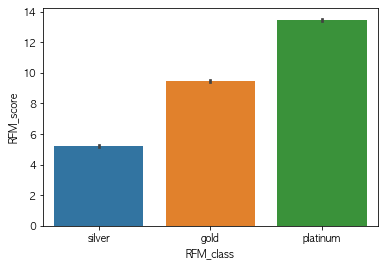

In [26]:
# RFM_class 별 평균 RFM_score
sns.barplot(data=rfm, x="RFM_class", y="RFM_score")

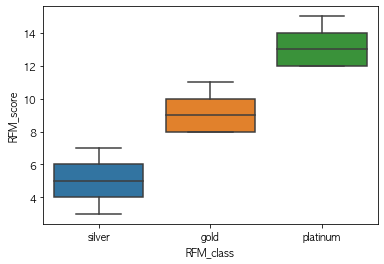

In [27]:
sns.boxplot(data=rfm, x="RFM_class", y="RFM_score")

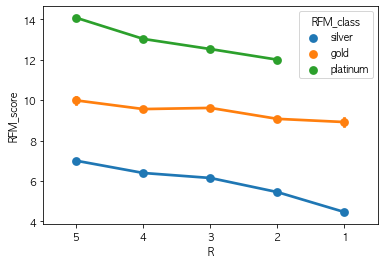

In [28]:
sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class")

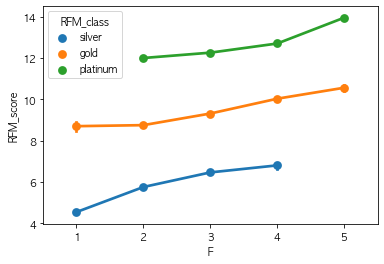

In [29]:
sns.pointplot(data=rfm, x="F", y="RFM_score", hue="RFM_class")

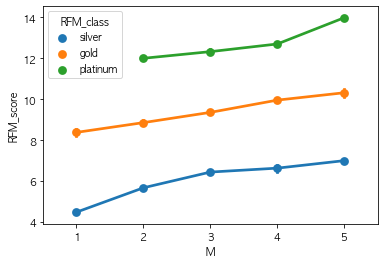

In [30]:
sns.pointplot(data=rfm, x="M", y="RFM_score", hue="RFM_class")

In [31]:
# "RFM_class" 별로 그룹화 하고 "Recency", "Frequency" 의 평균을 
# "MonetaryValue"의 "mean", "sum", "count" 값을 구합니다.
rfm_agg = rfm.groupby(["RFM_class"]).agg({
    "Recency": "mean", 
    "Frequency": "mean",
    "MonetaryValue" : ["mean", "sum", "count"]
})
rfm_agg

Recency   Frequency MonetaryValue                   
                 mean        mean          mean          sum count
RFM_class                                                         
silver     170.072542   17.068945    411.232339   685935.542  1668
gold        65.855926   55.664301   1005.104153  1416191.752  1409
platinum    19.949247  226.636796   5247.114988  6616612.000  1261

In [32]:
# 위에서 구한 값을 .style.background_gradient() 로 봅니다.
rfm_agg.astype(int).style.background_gradient().format("{:,}")

In [33]:
#.style.format("{:,}") 로 천단위 ,를 출력해 봅니다.
rfm_agg.astype(int).style.format("{:,}")

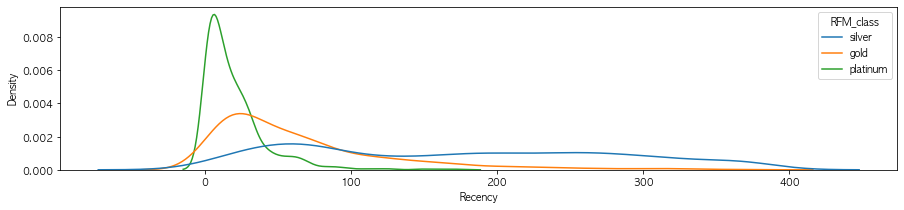

In [34]:
# kdeplot으로 Recency 의 RFM_class 별 분포를 그립니다.
plt.figure(figsize=(15, 3))
sns.kdeplot(data=rfm, x="Recency", hue="RFM_class")

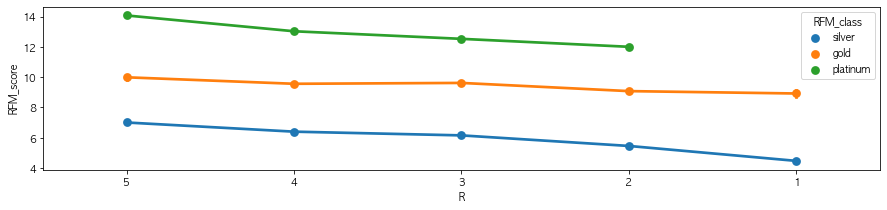

In [35]:
# pointplot 으로 Recency 의 RFM_class 별 분포를 그립니다.
plt.figure(figsize=(15, 3))
sns.pointplot(data=rfm, x="R", y="RFM_score", hue="RFM_class")

In [36]:
# 두 개의 그래프를 그리는 함수를 만듭니다.
def show_kde_point_plot(kde_x="Recency", point_x="R"):
    plt.figure(figsize=(15, 3))
    sns.kdeplot(data=rfm, x=kde_x, hue="RFM_class")
    plt.figure(figsize=(15, 3))
    sns.pointplot(data=rfm, x=point_x, y="RFM_score", hue="RFM_class")

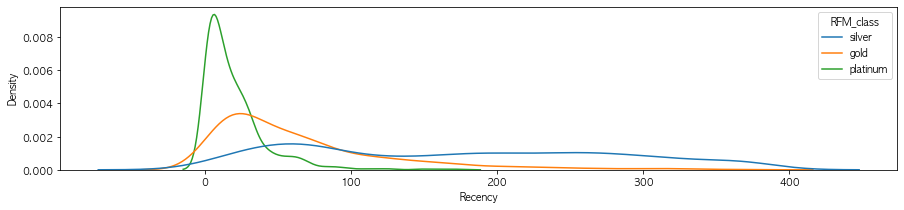

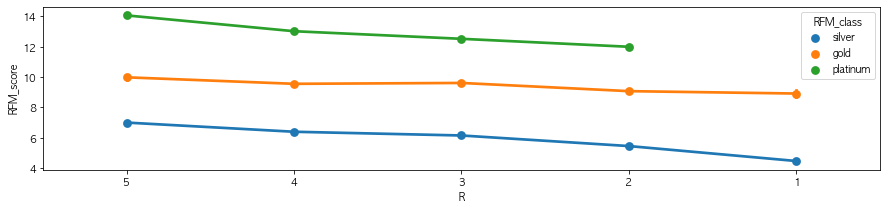

In [37]:
show_kde_point_plot(kde_x="Recency", point_x="R")

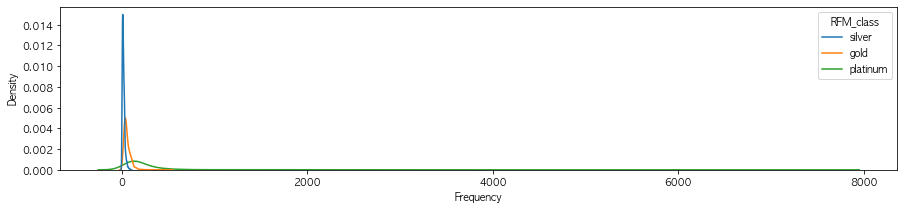

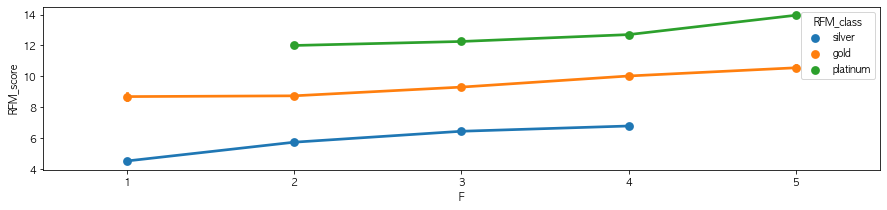

In [38]:
show_kde_point_plot(kde_x="Frequency", point_x="F")

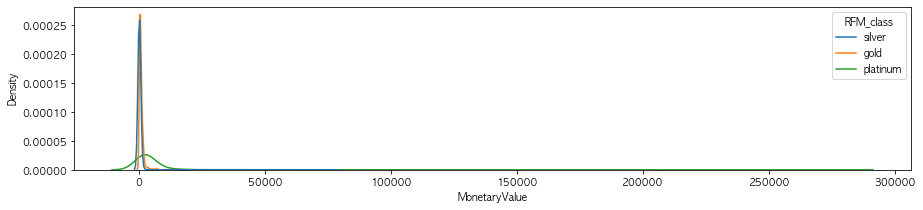

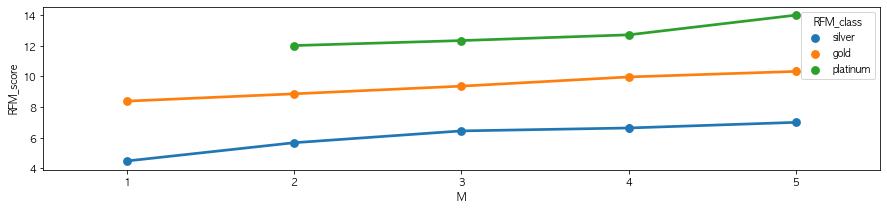

In [39]:
show_kde_point_plot(kde_x="MonetaryValue", point_x="M")

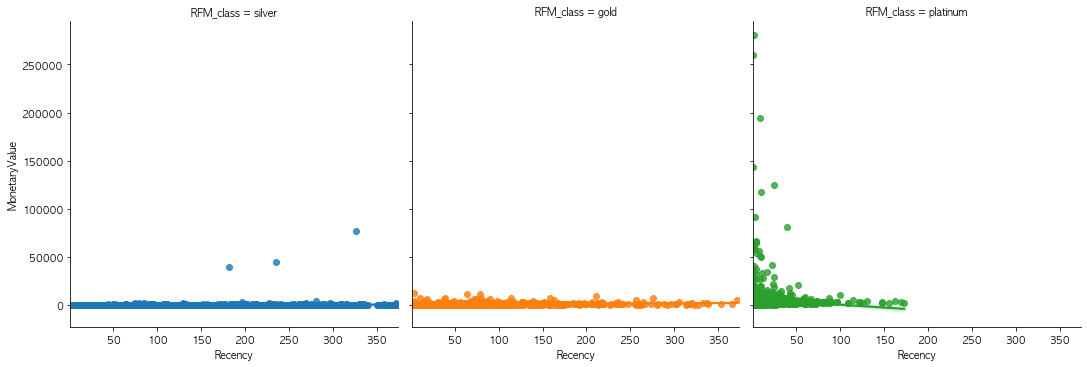

In [40]:
# lmplot 을 통해  x="Recency", y="MonetaryValue", hue="RFM_class", col="RFM_class" 값을 시각화 합니다.
sns.lmplot(data=rfm, x="Recency", y="MonetaryValue", hue="RFM_class", col="RFM_class")

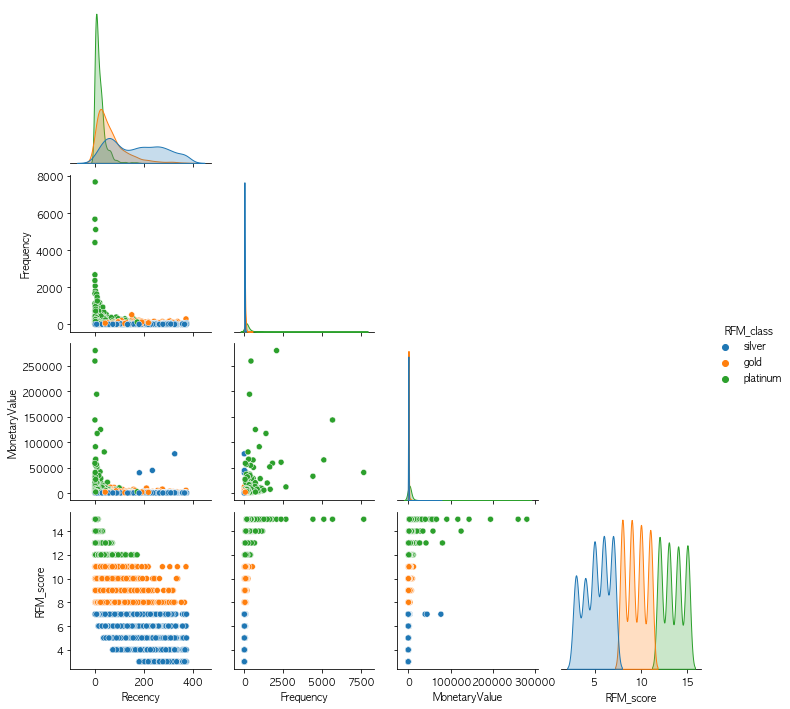

In [41]:
# pairplot 을 통해 "RFM_class" 별로 분포를 시각화 합니다.
sns.pairplot(data=rfm, hue="RFM_class", corner=True)

In [42]:
corr = rfm.corr()
corr

,Recency,Frequency,MonetaryValue,RFM_score
Recency,1.000000,-0.206618,-0.122937,-0.700621
Frequency,-0.206618,1.000000,0.444920,0.404260
MonetaryValue,-0.122937,0.444920,1.000000,0.250433
RFM_score,-0.700621,0.404260,0.250433,1.000000


In [43]:
mask = np.triu(np.ones_like(corr))
mask

array([[1., 1., 1., 1.],
       [0., 1., 1., 1.],
       [0., 0., 1., 1.],
       [0., 0., 0., 1.]])

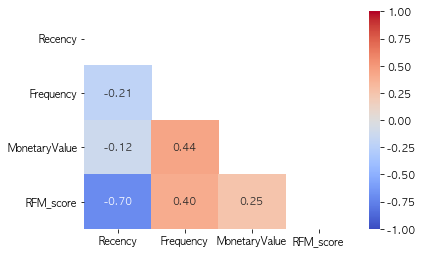

In [44]:
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", mask=mask, vmin=-1, vmax=1)

In [45]:
rfm.to_csv("rfm.csv", index=True)

In [46]:
pd.read_csv("rfm.csv").head(3)

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,RFM_class
0,12346.0,326,1,77183.60,1,1,5,115,7,silver
1,12347.0,2,182,4310.00,5,5,5,555,15,platinum
2,12348.0,75,31,1797.24,2,3,4,234,9,gold
